In [1]:
import pandas as pd
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

sns.set(
    font="Noto Sans",
    font_scale=1.5,
    style="whitegrid"
)
sns.set_palette([
    "#083A42",
    "#28a399",
    "#801650",
    "#FF5E00"
])

plans = pd.read_csv(
    "./data/plan_details.csv",
    low_memory=False,
    parse_dates=[5, 6]
)
plans = plans[["distributor", "brandName", "planId", "displayName", "planType", "effectiveFrom", "effectiveTo", "pricingModel"] + plans.columns[7:].drop("pricingModel").sort_values().tolist()]
plans.to_csv("./data/plan_details_ordered.csv", index=False)
plans

,distributor,brandName,planId,displayName,planType,effectiveFrom,effectiveTo,pricingModel,additionalInformation,benefitPeriod,...,tariffPeriod_3_timeOfUseRates_2_timeOfUse_1_startTime,tariffPeriod_3_timeOfUseRates_2_timeOfUse_2_days_0,tariffPeriod_3_timeOfUseRates_2_timeOfUse_2_days_1,tariffPeriod_3_timeOfUseRates_2_timeOfUse_2_endTime,tariffPeriod_3_timeOfUseRates_2_timeOfUse_2_startTime,tariffPeriod_3_timeOfUseRates_2_type,termType,terms,timeZone,variation
0,Endeavour,1st Energy,1ST679783MRE1@EME,1st Saver - Time of Use + Controlled Load 2,MARKET,2023-11-06 00:00:00+00:00,NaT,TIME_OF_USE_CONT_LOAD,Additional fees may apply. For more informatio...,Ongoing,...,NaN,NaN,NaN,NaN,NaN,NaN,ONGOING,For further details on the information present...,LOCAL,Prices may be varied in line with your terms a...
1,Ausgrid,1st Energy,1ST679774MRE1@EME,1st Saver - Time of Use,MARKET,2023-11-06 00:00:00+00:00,NaT,TIME_OF_USE,Additional fees may apply. For more informatio...,Ongoing,...,NaN,NaN,NaN,NaN,NaN,NaN,ONGOING,For further details on the information present...,LOCAL,Prices may be varied in line with your terms a...
2,Ausgrid,1st Energy,1ST679776MRE1@EME,1st Saver - Time of Use + Controlled Load 2,MARKET,2023-11-06 00:00:00+00:00,NaT,TIME_OF_USE_CONT_LOAD,Additional fees may apply. For more informatio...,Ongoing,...,NaN,NaN,NaN,NaN,NaN,NaN,ONGOING,For further details on the information present...,LOCAL,Prices may be varied in line with your terms a...
3,Ausgrid,1st Energy,1ST679772MRE1@EME,1st Saver - Single Rate + Controlled Load 2,MARKET,2023-11-06 00:00:00+00:00,NaT,SINGLE_RATE_CONT_LOAD,Additional fees may apply. For more informatio...,Ongoing,...,NaN,NaN,NaN,NaN,NaN,NaN,ONGOING,For further details on the information present...,NaN,Prices may be varied in line with your terms a...
4,Ausgrid,1st Energy,1ST679773MRE1@EME,1st Saver - Single Rate + Controlled Load 1 & 2,MARKET,2023-11-06 00:00:00+00:00,NaT,SINGLE_RATE_CONT_LOAD,Additional fees may apply. For more informatio...,Ongoing,...,NaN,NaN,NaN,NaN,NaN,NaN,ONGOING,For further details on the information present...,NaN,Prices may be varied in line with your terms a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,Ausgrid,Simply Energy,SIM590282SRE1@EME,NSW Small Office Standing Offer,STANDING,2023-07-01 00:00:00+00:00,NaT,TIME_OF_USE_CONT_LOAD,NaN,NaN,...,2000.0,NaN,NaN,2159.0,700.0,SHOULDER,NaN,For further details on the information present...,AEST,We will not vary our standing offer prices mor...
4872,Ausgrid,Simply Energy,SIM590267SRE1@EME,NSW Small Office Standing Offer,STANDING,2023-07-01 00:00:00+00:00,NaT,SINGLE_RATE_CONT_LOAD,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,For further details on the information present...,NaN,We will not vary our standing offer prices mor...
4873,Endeavour,Simply Energy,SIM590263SRE1@EME,NSW Small Office Standing Offer,STANDING,2023-07-01 00:00:00+00:00,NaT,TIME_OF_USE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,For further details on the information present...,AEST,We will not vary our standing offer prices mor...
4874,Endeavour,Simply Energy,SIM590249SRE1@EME,NSW Small Office Standing Offer,STANDING,2023-07-01 00:00:00+00:00,NaT,SINGLE_RATE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,For further details on the information present...,NaN,We will not vary our standing offer prices mor...


In [2]:
standingOffers = pd.read_csv(
    "./data/dmo.csv",
    thousands=",",
    converters={"dmoPrice": lambda x: float(re.sub(r"[$,]", "", x))}
)
standingOffers

,distributionZone,controlledLoad,dmoPrice,dmoElectricityEsage,dmoElectricityControlledLoadEsage
0,Ausgrid,False,1827.0,3911,NaN
1,Ausgrid,True,2562.0,4813,2005.0
2,Endeavour,False,2228.0,4913,NaN
3,Endeavour,True,2977.0,5214,2206.0
4,Essential Energy,False,2527.0,4613,NaN
5,Essential Energy,True,2977.0,4613,2005.0
6,Energex,False,1969.0,4613,NaN
7,Energex,True,2363.0,4412,1905.0
8,SA Power Networks,False,2279.0,4011,NaN
9,SA Power Networks,True,2787.0,4212,1805.0


In [81]:
dailyUsage = pd.DataFrame(
    columns=["distributor", "timeStart", "timeEnd", "usage"],
    index=[i for i in range(48 * 5)]
)
dailyUsage.iloc[[i for i in range(48)], 0] = "Ausgrid"
dailyUsage.iloc[[i for i in range(48, 48 * 2)], 0] = "Endeavour"
dailyUsage.iloc[[i for i in range(48 * 2, 48 * 3)], 0] = "Energex"
dailyUsage.iloc[[i for i in range(48 * 3, 48 * 4)], 0] = "Essential Energy"
dailyUsage.iloc[[i for i in range(48 * 4, 48 * 5)], 0] = "SA Power Networks"
dailyUsage.timeStart = [time.time() for time in pd.date_range("2024-01-01", periods=48, freq='30T')] * 5
dailyUsage.timeEnd = [time.time() for time in pd.date_range("2024-01-01 00:30:00", periods=48, freq='30T')] * 5
dailyUsage.usage = [
    0.2326, 0.2247, 0.2140, 0.1900, 0.1725, 0.1563, 0.1450, 0.1379, 0.1348, 0.1348, 0.1399, 0.1484, 0.1651, 0.1869, 0.2012, 0.2168, 0.2210, 0.2213, 0.2207, 0.2186, 0.2162, 0.2142, 0.2124, 0.2125, 0.2138, 0.2140, 0.2128, 0.2114, 0.2106, 0.2111, 0.2142, 0.2224, 0.2346, 0.2514, 0.2731, 0.2997, 0.3148, 0.3180, 0.3120, 0.3040, 0.2974, 0.2898, 0.2776, 0.2663, 0.2595, 0.2541, 0.2465, 0.2379,
    0.2959, 0.2865, 0.2601, 0.2252, 0.1991, 0.1805, 0.1692, 0.1628, 0.1619, 0.1647, 0.1740, 0.1864, 0.2078, 0.2336, 0.2473, 0.2642, 0.2682, 0.2651, 0.2653, 0.2642, 0.2621, 0.2604, 0.2589, 0.2607, 0.2623, 0.2626, 0.2617, 0.2636, 0.2677, 0.2728, 0.2826, 0.2999, 0.3201, 0.3445, 0.3679, 0.3984, 0.4127, 0.4124, 0.4021, 0.3912, 0.3791, 0.3656, 0.3483, 0.3255, 0.3194, 0.3196, 0.3144, 0.3062,
    0.1963, 0.1803, 0.1697, 0.1599, 0.1527, 0.1479, 0.1452, 0.1441, 0.1463, 0.1517, 0.1635, 0.1790, 0.2029, 0.2316, 0.2577, 0.2681, 0.2705, 0.2689, 0.2693, 0.2687, 0.2669, 0.2661, 0.2653, 0.2676, 0.2699, 0.2718, 0.2745, 0.2761, 0.2800, 0.2819, 0.2881, 0.2987, 0.3116, 0.3307, 0.3509, 0.3753, 0.3922, 0.3998, 0.3886, 0.3777, 0.3709, 0.3495, 0.3265, 0.3088, 0.2939, 0.2758, 0.2488, 0.2201,
    0.2723, 0.2719, 0.2638, 0.2516, 0.2309, 0.2069, 0.1882, 0.1764, 0.1714, 0.1712, 0.1793, 0.1924, 0.2147, 0.2365, 0.2458, 0.2582, 0.2597, 0.2536, 0.2535, 0.2512, 0.2486, 0.2468, 0.2439, 0.2411, 0.2429, 0.2430, 0.2416, 0.2388, 0.2387, 0.2401, 0.2452, 0.2557, 0.2685, 0.2854, 0.3138, 0.3493, 0.3708, 0.3723, 0.3605, 0.3474, 0.3365, 0.3233, 0.3147, 0.3091, 0.3114, 0.2981, 0.2856, 0.2802,
    0.2577, 0.3017, 0.2996, 0.2542, 0.2145, 0.1884, 0.1731, 0.1557, 0.1441, 0.1394, 0.1417, 0.1498, 0.1674, 0.1802, 0.2012, 0.2064, 0.2008, 0.1963, 0.1958, 0.2001, 0.2048, 0.2125, 0.2150, 0.2157, 0.2705, 0.3168, 0.3146, 0.2669, 0.2252, 0.1978, 0.1818, 0.1635, 0.1513, 0.1464, 0.1488, 0.1573, 0.1758, 0.1892, 0.2113, 0.2167, 0.2108, 0.2061, 0.2056, 0.2101, 0.2151, 0.2231, 0.2258, 0.2265
]
dailyUsage.to_csv("./data/dailyUsage_without_controlled_load.csv", index=False)
dailyUsage

,distributor,timeStart,timeEnd,usage
0,Ausgrid,00:00:00,00:30:00,0.2326
1,Ausgrid,00:30:00,01:00:00,0.2247
2,Ausgrid,01:00:00,01:30:00,0.2140
3,Ausgrid,01:30:00,02:00:00,0.1900
4,Ausgrid,02:00:00,02:30:00,0.1725
...,...,...,...,...
235,SA Power Networks,21:30:00,22:00:00,0.2101
236,SA Power Networks,22:00:00,22:30:00,0.2151
237,SA Power Networks,22:30:00,23:00:00,0.2231
238,SA Power Networks,23:00:00,23:30:00,0.2258


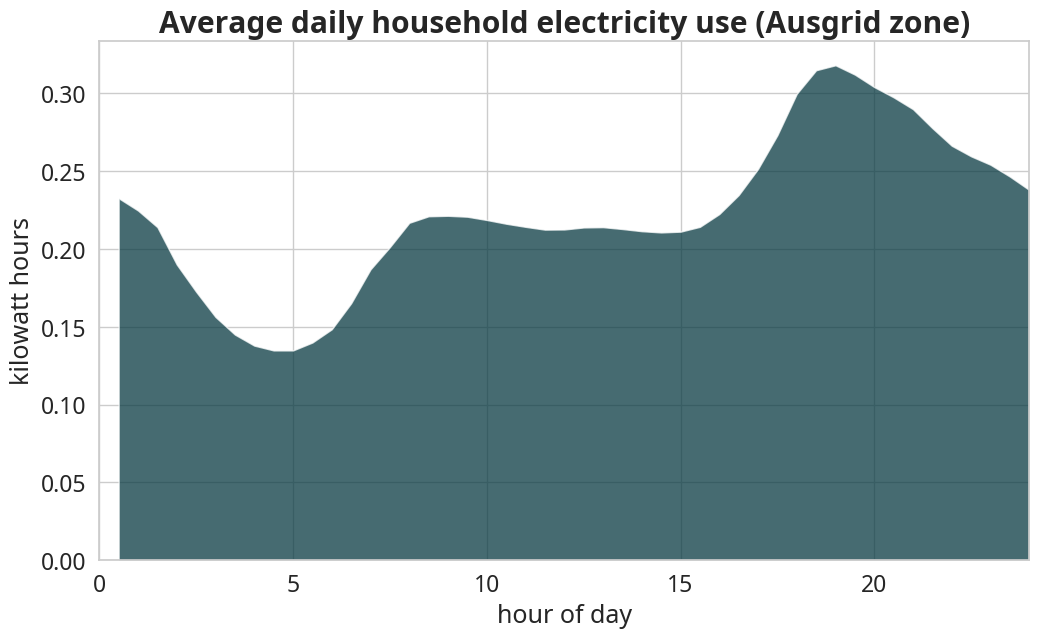

In [82]:
fig = plt.figure(figsize=(12, 6.75))
chartData = dailyUsage[dailyUsage.distributor == "Ausgrid"]
ax = plt.fill_between(
    chartData["timeEnd"].map(lambda x: 24 if (x.hour == 0) & (x.minute == 0) else x.hour + x.minute / 60),
    chartData["usage"],
    alpha=.75
)
plt.ylabel("kilowatt hours")
plt.xlabel("hour of day")
plt.xlim(0, 24)
plt.ylim(0,)
plt.title("Average daily household electricity use (Ausgrid zone)", fontsize="large", fontweight="bold")
plt.show()

In [125]:
relevant_plans = relevant_plans[
    (relevant_plans.pricingModel == "SINGLE_RATE") &
    (pd.isna(relevant_plans.tariffPeriod_1_startDate)) &
    (pd.isna(relevant_plans.tariffPeriod_0_demandCharges_0_amount)) &
    (pd.isna(relevant_plans.tariffPeriod_0_singleRate_rates_1_unitPrice))
]

def calculate_demand_charges(planId):
    annualUsage = prices.at[planId, "annualUsage"]
    tariffPrice = relevant_plans.at[planId, "tariffPeriod_0_singleRate_rates_0_unitPrice"] / 100
    return annualUsage * tariffPrice
    
relevant_plans.columns
prices = relevant_plans.iloc[:, :6]
prices["dmoPrice"] = prices.distributor.map(lambda x: standingOffers[(standingOffers.distributionZone == x) & (standingOffers.controlledLoad == False)].iloc[0, 2])
prices["annualUsage"] = prices.distributor.map(lambda x: standingOffers[(standingOffers.distributionZone == x) & (standingOffers.controlledLoad == False)].iloc[0, 3])
prices["supplyCharge"] = relevant_plans.tariffPeriod_0_dailySupplyCharges * 366 / 100
prices["demandCharge"] = prices.index.map(calculate_demand_charges)
prices["estimatedCharge"] = prices.supplyCharge + prices.demandCharge
prices["differenceDmoPrice"] = prices.estimatedCharge - prices.dmoPrice
prices.to_csv("./data/priceEstimates.csv")
prices

,distributor,brandName,displayName,planType,effectiveFrom,effectiveTo,dmoPrice,annualUsage,supplyCharge,demandCharge,estimatedCharge,differenceDmoPrice
planId,,,,,,,,,,,,
ACT670962MRE1@EME,Endeavour,ActewAGL,Simple Saver,MARKET,2023-11-04 00:00:00+00:00,2024-06-30 00:00:00+00:00,2228.0,4913,362.3400,1298.417466,1660.757466,-567.242534
ACT657786MRE1@EME,Endeavour,ActewAGL,Solar Saver 5% - single rate,MARKET,2023-09-05 00:00:00+00:00,2024-06-30 00:00:00+00:00,2228.0,4913,376.9800,1547.595000,1924.575000,-303.425000
ACT345580MRE5@EME,Endeavour,ActewAGL,Battery Saver,MARKET,2023-07-04 00:00:00+00:00,2024-06-30 00:00:00+00:00,2228.0,4913,409.9200,1615.119272,2025.039272,-202.960728
ACT64408SRE6@EME,Endeavour,ActewAGL,Home plan,STANDING,2023-07-01 00:00:00+00:00,2024-06-30 00:00:00+00:00,2228.0,4913,409.9200,1615.119272,2025.039272,-202.960728
ALI683091MRE2@EME,Energex,Alinta Energy,BetterDeal - Single Rate,MARKET,2023-12-01 00:00:00+00:00,NaT,1969.0,4613,419.8020,1370.061000,1789.863000,-179.137000
...,...,...,...,...,...,...,...,...,...,...,...,...
TAN658245MRE1@EME,Energex,Tango Energy,eSelect,MARKET,2023-08-31 00:00:00+00:00,NaT,1969.0,4613,355.0200,1416.191000,1771.211000,-197.789000
TAN658235MRE1@EME,Ausgrid,Tango Energy,eSelect,MARKET,2023-08-31 00:00:00+00:00,NaT,1827.0,3911,259.8600,1243.698000,1503.558000,-323.442000
TAN658250MRE1@EME,Energex,Tango Energy,Home Select,MARKET,2023-08-31 00:00:00+00:00,NaT,1969.0,4613,366.0000,1416.191000,1782.191000,-186.809000


In [117]:
prices[prices.differenceDmoPrice >= 0]

,distributor,brandName,displayName,planType,effectiveFrom,effectiveTo,dmoPrice,annualUsage,supplyCharge,demandCharge,estimatedCharge,differenceDmoPrice
planId,,,,,,,,,,,,
AMB698648MRE1@EME,Energex,Amber,CommBank Homeowner Offer,MARKET,2024-01-02 00:00:00+00:00,NaT,1969.0,4613,359.3388,1628.741987,1988.080787,19.080787
AMB698601MRE1@EME,Energex,Amber,Amber Plan TOU,MARKET,2024-01-02 00:00:00+00:00,NaT,1969.0,4613,352.7508,1628.741987,1981.492787,12.492787
AMB698582MRE1@EME,Energex,Amber,Amber Plan,MARKET,2024-01-02 00:00:00+00:00,NaT,1969.0,4613,359.3388,1628.741987,1988.080787,19.080787
AMB698630MRE1@EME,Energex,Amber,CommBank,MARKET,2024-01-02 00:00:00+00:00,NaT,1969.0,4613,359.3388,1628.741987,1988.080787,19.080787
AMB698636MRE1@EME,Energex,Amber,CommBank Everyday Offer,MARKET,2024-01-02 00:00:00+00:00,NaT,1969.0,4613,359.3388,1628.741987,1988.080787,19.080787
AMB698642MRE1@EME,Energex,Amber,CommBank Everyday Plus Offer,MARKET,2024-01-02 00:00:00+00:00,NaT,1969.0,4613,359.3388,1628.741987,1988.080787,19.080787
LCL663168MRE3@EME,Endeavour,Energy Locals,TEP - ToU 23 Pre Smart Meter + Powerwall Credit,MARKET,2023-10-05 00:00:00+00:00,NaT,2228.0,4913,449.1918,2322.509078,2771.700878,543.700878
LCL663180MRE3@EME,Essential Energy,Energy Locals,TEP - ToU 23 Pre Smart Meter + Powerwall Credit,MARKET,2023-10-05 00:00:00+00:00,NaT,2527.0,4613,632.1918,2096.818161,2729.009961,202.009961
LCL663182MRE3@EME,Essential Energy,Energy Locals,TEP - ToU 23 Pre Smart Meter + $100 Welcome Cr...,MARKET,2023-10-05 00:00:00+00:00,NaT,2527.0,4613,632.1918,2096.818161,2729.009961,202.009961


In [121]:
prices[prices.estimatedCharge >= prices.dmoPrice].estimatedCharge - prices[prices.estimatedCharge >= prices.dmoPrice].dmoPrice
len(prices[prices.estimatedCharge >= prices.dmoPrice])

17

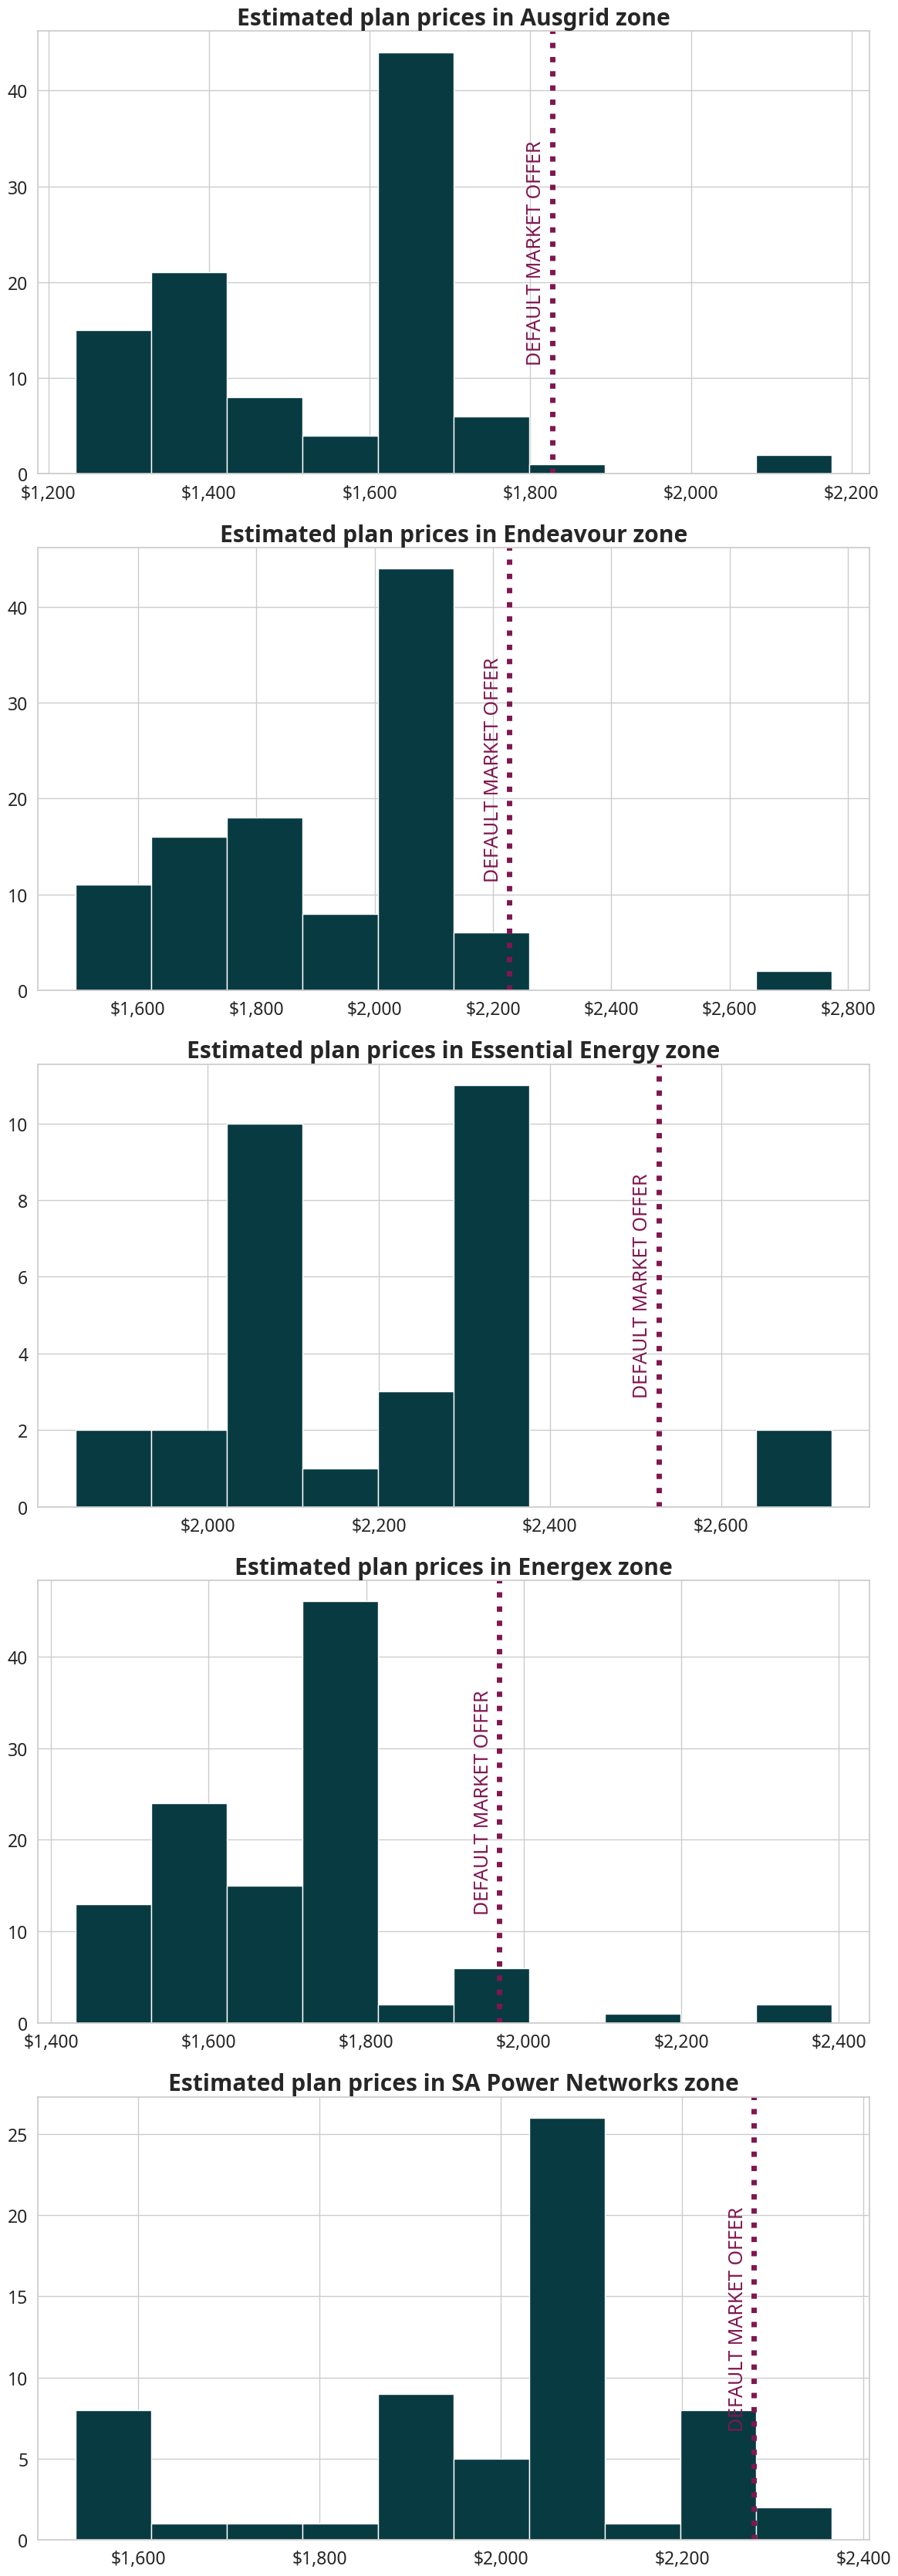

In [124]:
fig, ax = plt.subplots(
    5, 1,
    figsize=(12, 6.75 * 5),
    tight_layout=True
)

for i in range(5):
    distributor = standingOffers.at[i * 2, "distributionZone"]
    dmoPrice = standingOffers.at[i * 2, "dmoPrice"]
    ax[i].hist(
        x=prices[prices.distributor == distributor].estimatedCharge
    )
    ax[i].axvline(
        x=dmoPrice,
        linewidth=5,
        linestyle="dotted",
        color="C2"
    )
    ax[i].annotate(
        "DEFAULT MARKET OFFER",
        xy=(dmoPrice, ax[i].get_ylim()[1] / 2),
        xytext=(-15, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        rotation=90,
        color="C2"
    )
    ax[i].set_title(f"Estimated plan prices in {distributor} zone", fontweight="bold", fontsize="large")
    ax[i].xaxis.set_major_formatter(lambda x, p: f"${x:,.0f}")
plt.show()

        

In [86]:
[col for col in relevant_plans if "tariffPeriod_0_demand" in col]

['tariffPeriod_0_demandCharges_0_amount',
 'tariffPeriod_0_demandCharges_0_chargePeriod',
 'tariffPeriod_0_demandCharges_0_days_saturday',
 'tariffPeriod_0_demandCharges_0_days_sunday',
 'tariffPeriod_0_demandCharges_0_days_weekdays',
 'tariffPeriod_0_demandCharges_0_description',
 'tariffPeriod_0_demandCharges_0_displayName',
 'tariffPeriod_0_demandCharges_0_endTime',
 'tariffPeriod_0_demandCharges_0_measurementPeriod',
 'tariffPeriod_0_demandCharges_0_startTime',
 'tariffPeriod_0_demandCharges_1_amount',
 'tariffPeriod_0_demandCharges_1_chargePeriod',
 'tariffPeriod_0_demandCharges_1_days_saturday',
 'tariffPeriod_0_demandCharges_1_days_sunday',
 'tariffPeriod_0_demandCharges_1_days_weekdays',
 'tariffPeriod_0_demandCharges_1_description',
 'tariffPeriod_0_demandCharges_1_displayName',
 'tariffPeriod_0_demandCharges_1_endTime',
 'tariffPeriod_0_demandCharges_1_measurementPeriod',
 'tariffPeriod_0_demandCharges_1_startTime',
 'tariffPeriod_0_demandCharges_2_amount',
 'tariffPeriod_0_d